# PX912: Solid Mechanics - Workshop 5

This workshop expands on the single finite element solution procedure described in Workshop 4 onto multiple finite elements. 

The first part of this workshop relates to a simple finite element mesh generator - it uses 2D four-node linear quads to discretize simple 2D domains. The generator can be used in your own project. 

The second part of this workshop includes main steps involved in a FE solution with multiple finite elements. These solution steps involved in this workshop will constitute the major component of your coursework project. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# sympy isn't essential, but you might want to borrow code
# from Workshop 4.
# SymPy Library: Symbolic Python
import sympy as sym
sym.init_printing()
#plt.rc('figure', figsize=(18,15))

In [2]:
# mesh generation function 

### I. Mesh generator - brief description 
In the previous workshop, the finite element procedure was carried out on a single element. For this workshop, as well as your coursework, you'll be working with a larger number of elements.

The FEM solution is influenced by the number of elements used, the number of nodes per element, the nature of shape functions, or integration rules. All this results in a *discretization error*.  

Hence, appropriate discretization (or simply *meshing*) is important. One can come up with their own *meshing* technique or use tools available online. Here is a simple approach we recommend for your project.

We are going to recreate this mesh plot.

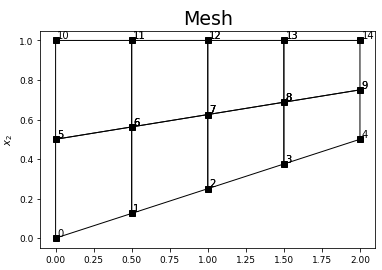

As you can see, you need to specify the coordinates on the boundary of the shape.

In [3]:
bot = [0, 0.5, 1, 1.5, 2]                               # x-coordinates of bottom side nodes
top = [0, 0.5, 1, 1.5, 2]                               # x-coordinates of top side nodes
left = [0, 0.5, 1]                                      # y-coordinates of left-hand side nodes 
right = [0.5, 0.75, 1]                                  # y-coordinates nodes of right-hand side nodes

Time for some bookkeeping. 
1. How many horizontal nodes do we have? How many elements?
2. How many verticle nodes do we have? How many elements?
3. What is the total number of nodes?

In [4]:
nnodesx = len(bot)                                      # number of horizontal nodes
nnodesy = len(left)                                     # number of vertical nodes 
nelx = nnodesx-1                                        # number of horizontal elements
nely = nnodesy-1                                        # number of vertical elements
nnodes = nnodesx*nnodesy                                # total number of nodes   

nnodesx, nnodesy, nelx, nely, nnodes

Now we generate the positions of each node. 

In [5]:
# length of RVE, x and y
lx = bot[nnodesx-1] - bot[0]
ly = left[nnodesy-1] - left[0]

# GENERATE COORDINATES OF NODES 'XYZ'
XYZ = np.zeros((nnodes,2))            
for i in range(nnodesy):
    yl = left[i] - left[0]
    dy = right[i] - left[i]
    for j in range(nnodesx):
        xb = bot[j] - bot[0]
        dx = top[j] - bot[j]

        x = (dx*yl+xb*ly)/(ly-dx*dy/lx)
        y = dy/lx*x+yl

        XYZ[j+i*nnodesx, 0] = x + bot[0] 
        XYZ[j+i*nnodesx, 1] = y + left[0]
        
XYZ

array([[0.    , 0.    ],
       [0.5   , 0.125 ],
       [1.    , 0.25  ],
       [1.5   , 0.375 ],
       [2.    , 0.5   ],
       [0.    , 0.5   ],
       [0.5   , 0.5625],
       [1.    , 0.625 ],
       [1.5   , 0.6875],
       [2.    , 0.75  ],
       [0.    , 1.    ],
       [0.5   , 1.    ],
       [1.    , 1.    ],
       [1.5   , 1.    ],
       [2.    , 1.    ]])

It is very useful to find the node numbers for each element. Write a routine that returns the node numbers for each element. For example, the first three elements should have node numbers:
```
[0, 1, 6, 5], [1, 2, 7, 6], [2, 3, 8, 7]
```
Note the direction that the nodes are being registered. Keep this consistent!

In [6]:
# NODE NUMBERS FOR ELEMENTS 
nel = nelx*nely
CON = np.zeros((nel,4), dtype=int)
for i in range(nely):
    for j in range(nelx):
        # element 'el' and corresponding node numbers
        CON[j+i*nelx, :] = [j+i*nnodesx, j+i*nnodesx+1,j+(i+1)*nnodesx+1, j+(i+1)*nnodesx] 
CON

array([[ 0,  1,  6,  5],
       [ 1,  2,  7,  6],
       [ 2,  3,  8,  7],
       [ 3,  4,  9,  8],
       [ 5,  6, 11, 10],
       [ 6,  7, 12, 11],
       [ 7,  8, 13, 12],
       [ 8,  9, 14, 13]])

Finally, we should determine the degrees of freedom from the node numbers for each element. For the first element, you should get:
```
[ 0,  1,  2,  3, 12, 13, 10, 11]
```

In [7]:
# Global DOF for each element (4-node (linear) quadrilateral element)
DOF = np.zeros((nel,2*4), dtype=int)
for i in range(nel):
    # defines single row of DOF for each element 'i'
    DOF[i,:] = [CON[i,0]*2, CON[i,1]*2-1, CON[i,1]*2, CON[i,1]*2+1,CON[i,2]*2, CON[i,2]*2+1, CON[i,3]*2, CON[i,3]*2+1]

DOF

array([[ 0,  1,  2,  3, 12, 13, 10, 11],
       [ 2,  3,  4,  5, 14, 15, 12, 13],
       [ 4,  5,  6,  7, 16, 17, 14, 15],
       [ 6,  7,  8,  9, 18, 19, 16, 17],
       [10, 11, 12, 13, 22, 23, 20, 21],
       [12, 13, 14, 15, 24, 25, 22, 23],
       [14, 15, 16, 17, 26, 27, 24, 25],
       [16, 17, 18, 19, 28, 29, 26, 27]])

Now, generalise your routines to work for any set of boundary coordinates. Write these in function form so that the code might be reused.

In [8]:
def mesh(bot,top,left,right):
    # returns [XYZ, CON, DOF] 
    # XYZ - array of nodal coordinates [number of elements x 2]
    # CON - array of node numbers for elements (linear QUADS [number of elements x 4])
    # DOF - array of element DOFs (4-node (linear) quadrilateral element => [number of elements x 8]); 
    
    # number of nodes and element in the RVE
    nnodesx = len(bot)                     # number of horizontal nodes
    nnodesy = len(left)                    # number of vertical nodes 
    nelx = nnodesx-1                       # number of horizontal elements
    nely = nnodesy-1                       # number of vertical elements
    nnodes = nnodesx*nnodesy               # total number of nodes    

    # length of RVE
    lx = bot[nnodesx-1] - bot[0]           # length of RVE in x-direction (horizontal)
    ly = left[nnodesy-1] - left[0]         # length of RVE in y-direction (vertical)

    # GENERATE COORDINATES OF NODES 'XYZ'
    XYZ = np.zeros((nnodes,2))            # two-column array [nnodes x 2] containing all nodal coordinates  
    for i in range(nnodesy):              # loop over all nodes on the vertical sides 
        yl = left[i] - left[0]            # distance between node 'i' and left-bottom node '1'
        dy = right[i] - left[i]           # distance between the corresponing nodes j on top and bottom 
        for j in range(nnodesx):          # loop over all nodes on the horizontal sides
            xb = bot[j] - bot[0]          # distance between node 'j' and bottom-left node '1' 
            dx = top[j] - bot[j]          # distance between nodes 'j' on opposite sides (top and bottom)

            x = (dx*yl+xb*ly)/(ly-dx*dy/lx) # x-coordinate (horizontal) of a node in the interior of RVE
            y = dy/lx*x+yl                  # y-coordinate (vertical) of a node in the interior of RVE

            XYZ[j+i*nnodesx, 0] = x + bot[0]  # coordinate 'x' in the global coordinate system 
            XYZ[j+i*nnodesx, 1] = y + left[0] # coordinate 'y' in the global coordinate system

    # NODE NUMBERS FOR ELEMENTS 
    nel = nelx*nely                              # total number of elements in RVE
    CON = np.zeros((nel,4), dtype=int)           # [nel*4] array of node number for each element
    for i in range(nely):                        # loop over elements in the vertical direction 
        for j in range(nelx):                    # loop over elements in the horizontal direction 
            # element 'el' and corresponding node numbers
            CON[j+i*nelx, :] = [j+i*nnodesx, j+i*nnodesx+1,j+(i+1)*nnodesx+1, j+(i+1)*nnodesx] 

    # Global DOF for each element (4-node (linear) quadrilateral element)
    DOF = np.zeros((nel,2*4), dtype=int)
    for i in range(nel):
        # defines single row of DOF for each element 'i'
        DOF[i,:] = [CON[i,0]*2, CON[i,1]*2-1, CON[i,1]*2, CON[i,1]*2+1,CON[i,2]*2, CON[i,2]*2+1, CON[i,3]*2, CON[i,3]*2+1]
        
    return XYZ, CON, DOF

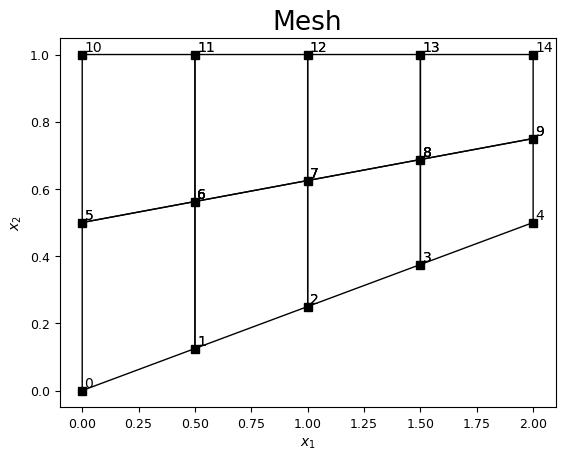

In [9]:
# Plotting routine: 
# plot the mesh 
plt.plot(XYZ[:, 0], XYZ[:, 1], 'sk')

for i in range(len(CON)):
    plt.fill(XYZ[CON[i, :], 0], XYZ[CON[i, :], 1], edgecolor='k', fill=False)

for i in range(4):                             #loop over all nodes within an element
    for j in range(len(CON)):                  #loop over all elements
        sh=0.01
        plt.text(XYZ[CON[j,i],0]+sh,XYZ[CON[j,i],1]+sh, CON[j,i])


# Set chart title.
plt.title("Mesh", fontsize=19)
# Set x axis label.
plt.xlabel("$x_1$", fontsize=10)
# Set y axis label.
plt.ylabel("$x_2$", fontsize=10)
# Set size of tick labels.
plt.tick_params(axis='both', which='major', labelsize=9)

plt.show()

## II. Finite element solution procedure with multiple finite elements

The steps suggested below are related to your coursework. 

Detailed guidance cannot be given, but everything you need can be found in the previous two workshops.

### II.1. Mesh

In [10]:
def XYZ(bot,top,left,right):
    nnodesx = len(bot)                     # number of horizontal nodes
    nnodesy = len(left)                    # number of vertical nodes 
    nelx = nnodesx-1                       # number of horizontal elements
    nely = nnodesy-1                       # number of vertical elements
    nnodes = nnodesx*nnodesy               # total number of nodes    

    # length of RVE
    lx = bot[nnodesx-1] - bot[0]           # length of RVE in x-direction (horizontal)
    ly = left[nnodesy-1] - left[0]         # length of RVE in y-direction (vertical)

    # GENERATE COORDINATES OF NODES 'XYZ'
    XYZ = np.zeros((nnodes,2))            # two-column array [nnodes x 2] containing all nodal coordinates  
    for i in range(nnodesy):              # loop over all nodes on the vertical sides 
        yl = left[i] - left[0]            # distance between node 'i' and left-bottom node '1'
        dy = right[i] - left[i]           # distance between the corresponing nodes j on top and bottom 
        for j in range(nnodesx):          # loop over all nodes on the horizontal sides
            xb = bot[j] - bot[0]          # distance between node 'j' and bottom-left node '1' 
            dx = top[j] - bot[j]          # distance between nodes 'j' on opposite sides (top and bottom)

            x = (dx*yl+xb*ly)/(ly-dx*dy/lx) # x-coordinate (horizontal) of a node in the interior of RVE
            y = dy/lx*x+yl                  # y-coordinate (vertical) of a node in the interior of RVE

            XYZ[j+i*nnodesx, 0] = x + bot[0]  # coordinate 'x' in the global coordinate system 
            XYZ[j+i*nnodesx, 1] = y + left[0] # coordinate 'y' in the global coordinate system
        nel = nelx*nely                              # total number of elements in RVE
    CON = np.zeros((nel,4), dtype=int)           # [nel*4] array of node number for each element
    for i in range(nely):                        # loop over elements in the vertical direction 
        for j in range(nelx):                    # loop over elements in the horizontal direction 
            # element 'el' and corresponding node numbers
            CON[j+i*nelx, :] = [j+i*nnodesx, j+i*nnodesx+1,j+(i+1)*nnodesx+1, j+(i+1)*nnodesx] 

    return XYZ, nelx, nely, nnodesx, nnodesy, CON,nel

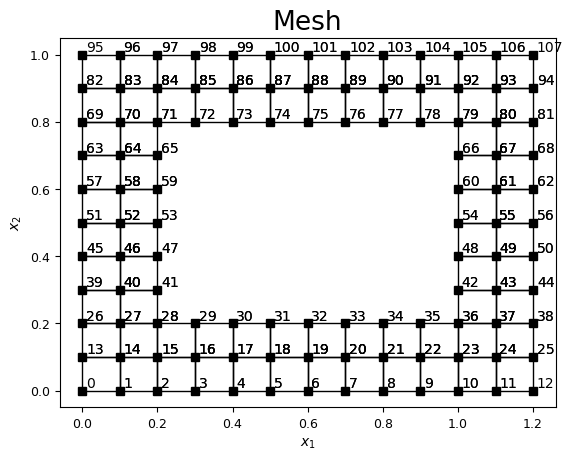

array([[  0,   1,   2,   3,  28,  29,  26,  27],
       [  2,   3,   4,   5,  30,  31,  28,  29],
       [  4,   5,   6,   7,  32,  33,  30,  31],
       [  6,   7,   8,   9,  34,  35,  32,  33],
       [  8,   9,  10,  11,  36,  37,  34,  35],
       [ 10,  11,  12,  13,  38,  39,  36,  37],
       [ 12,  13,  14,  15,  40,  41,  38,  39],
       [ 14,  15,  16,  17,  42,  43,  40,  41],
       [ 16,  17,  18,  19,  44,  45,  42,  43],
       [ 18,  19,  20,  21,  46,  47,  44,  45],
       [ 20,  21,  22,  23,  48,  49,  46,  47],
       [ 22,  23,  24,  25,  50,  51,  48,  49],
       [ 26,  27,  28,  29,  54,  55,  52,  53],
       [ 28,  29,  30,  31,  56,  57,  54,  55],
       [ 30,  31,  32,  33,  58,  59,  56,  57],
       [ 32,  33,  34,  35,  60,  61,  58,  59],
       [ 34,  35,  36,  37,  62,  63,  60,  61],
       [ 36,  37,  38,  39,  64,  65,  62,  63],
       [ 38,  39,  40,  41,  66,  67,  64,  65],
       [ 40,  41,  42,  43,  68,  69,  66,  67],
       [ 42,  43,  4

In [11]:
##################################################################################################################
############################# NOTE: To change density of nodes ###################################################
############################# only need to change value of 'n' ###################################################
##################################################################################################################

n = 2             ################### n = 1,2,3,4,5 sets the density of the mesh!!!!!!!!!!!################ 
if n == 1:
    bot = np.linspace(0.0,1.2,7, endpoint =True)
    top=bot
    left = np.linspace(0.0,1.0,6, endpoint =True)
    right = left    
elif n==2:
    bot = np.linspace(0.0,1.2,13, endpoint =True)
    top=bot
    left = np.linspace(0.0,1.0,11, endpoint =True)
    right = left
elif n == 3:
    bot = np.linspace(0.0,1.2,25, endpoint =True)
    top=bot
    left = np.linspace(0.0,1.0,21, endpoint =True)
    right = left
elif n == 4:
    bot = np.linspace(0.0,1.2,49, endpoint =True)
    top=bot
    left = np.linspace(0.0,1.0,41, endpoint =True)
    right = left
elif n ==5:
    bot = np.linspace(0.0,1.2,97, endpoint =True)
    top=bot
    left = np.linspace(0.0,1.0,81, endpoint =True)
    right = left
XYZ1, nelx1, nely1 ,nnodesx1, nnodesy1, CON, nel1= XYZ(bot,top,left,right)

#--------------------------------------


if n == 1:
    bot = np.linspace(0.2,1.0,5, endpoint =True)
    top=bot
    left = np.linspace(0.2,0.8,4, endpoint =True)
    right = left    
elif n==2:
    bot = np.linspace(0.2,1.0,9, endpoint =True)
    top=bot
    left = np.linspace(0.2,0.8,7, endpoint =True)
    right = left
elif n == 3:
    bot = np.linspace(0.2,1.0,17, endpoint =True)
    top=bot
    left = np.linspace(0.2,0.8,13, endpoint =True)
    right = left
elif n == 4:
    bot = np.linspace(0.2,1.0,33, endpoint =True)
    top=bot
    left = np.linspace(0.2,0.8,25, endpoint =True)
    right = left
elif n == 5:
    bot = np.linspace(0.2,1.0,65, endpoint =True)
    top=bot
    left = np.linspace(0.2,0.8,49, endpoint =True)
    right = left
XYZ2, nelx2, nely, nnodesx2, nnodesy2, CON2, nel2 = XYZ(bot,top,left,right)

#--------------------------------------

#Generate resulting mesh

jstore = []
for j,i in enumerate(XYZ2):   #shave deleted points
    if - 0.00000000001 < (i[0] - 0.2) < 0.00000000001:
        jstore.append(j)
    elif - 0.00000000001 < (i[0] - 1.0) < 0.00000000001:
        jstore.append(j)
    elif - 0.00000000001 < (i[1] - 0.2) < 0.00000000001:
        jstore.append(j)
    elif - 0.00000000001 < (i[1] - 0.8) < 0.00000000001:
        jstore.append(j)
    
for i in reversed(jstore):
    XYZ2 = np.delete(XYZ2, i, axis = 0)
#print(XYZ2)    


jstore1 = []
jstore2 = []
jstore3 = []
for i in range(len(XYZ2)):
    for j in range(len(XYZ1)):
        if (-0.00001<(float(XYZ2[i,0]) - float(XYZ1[j,0])) < 0.000001) and (-0.000001<(float(XYZ2[i,1]) - float(XYZ1[j,1])) < 0.0001):  #ISSUE COMING FROM HERE
            jstore1.append(j)            
        #elif XYZ2[i,0] != XYZ1[j,0] and XYZ2[i,1] != XYZ1[j,1]:
        #    jstore2.append(j)
        #else:
        #    jstore3.append(j)
        #    print('node', j, 'not tested well')
        
#print(jstore1)
for i in reversed(jstore1):
    XYZ1 = np.delete(XYZ1, i, axis = 0)
XYZ = XYZ1
#print(XYZ)

fifthny = int(nely1/5)
sixthnx = int(nelx1/6)
CON1 = []
for i in range((nelx1*fifthny)+sixthnx):  #does bottom
    CON1.append(list(CON[i]))
#print(CON1)
(nelx1-(2*sixthnx)) #does middle
start_noder = (nelx1*(fifthny+1))
start_nodel = nnodesx1 * (fifthny+1)
#print(start_noder,start_nodel)
start_node_arr = []
for i in range(sixthnx):
    start_node_arr.append(start_noder+i)
for i in range(sixthnx):
    start_node_arr.append(start_nodel+i)


#print(start_node_arr) #[36,37,39,40]
#------------------------------------------------------------------------------------
ijstore= []

for i in range(int(((nely1/5)*3)-1)):
        for j in start_node_arr:#120, 121, 122, 123, 125, 126, 127, 128
            #ijstore.append(j+(i+1)*(nelx1-((sixthnx+1)*sixthnx)))
            ijstore.append(j + ((i+1)*(sixthnx+sixthnx+2)))
#print(ijstore)
for i in ijstore:
    start_node_arr.append(i)
start_node_arr = start_node_arr[0:-2*sixthnx] # could be a source of error!
############################################################
#print(start_node_arr)
#print(start_node_arr)
for i in start_node_arr:
    CON1.append([i, i+1, i+1+(sixthnx+sixthnx+2),i+(sixthnx+sixthnx+2)])
    #CON1.append([i, i+1, i+1+(nelx1-((sixthnx+1)*sixthnx)),i+(nelx1-((sixthnx+1)*sixthnx))])

start_end_1_arr = []   
start_end_1  = ijstore[-2*sixthnx-1]+2
#print(start_end_1)
for i in range(sixthnx):
    start_end_1_arr.append(start_end_1 + i)
for i in start_end_1_arr:
    CON1.append([i, i+1, i+1+nnodesx1, i+nnodesx1])
#print(start_end_1_arr)

start_end_2 = start_end_1_arr[-1] +2
start_end_2_arr = []
for i in range((int(nnodesx1)*(fifthny)-1)):
    start_end_2_arr.append(start_end_2+i)
#print(start_end_2_arr)
del_nodes_store = []
if len(start_end_2_arr)>nnodesx1:
    for i in range(1,fifthny):
        del_nodes_store.append((i*nnodesx1)-1)
for i in reversed(del_nodes_store):
    del start_end_2_arr[i]
#print(start_end_2_arr)
for i in start_end_2_arr:
    CON1.append([i, i+1, i+1+nnodesx1, i+nnodesx1])
    
CON1 = np.array(CON1)

plt.plot(XYZ[:, 0], XYZ[:, 1], 'sk')

for i in range(len(CON1)):
    plt.fill(XYZ[CON1[i, :], 0], XYZ[CON1[i, :], 1], edgecolor='k', fill=False)

for i in range(4):                             #loop over all nodes within an element
    for j in range(len(CON1)):                  #loop over all elements
        sh=0.01
        plt.text(XYZ[CON1[j,i],0]+sh,XYZ[CON1[j,i],1]+sh, CON1[j,i])
nel = nel1-nel2
DOF = np.zeros((nel,2*4), dtype=int)
for i in range(nel):
        # defines single row of DOF for each element 'i'
    DOF[i,:] = [CON1[i,0]*2, CON1[i,1]*2-1, CON1[i,1]*2, CON1[i,1]*2+1,CON1[i,2]*2, CON1[i,2]*2+1, CON1[i,3]*2, CON1[i,3]*2+1]


# Set chart title.
plt.title("Mesh", fontsize=19)
# Set x axis label.
plt.xlabel("$x_1$", fontsize=10)
# Set y axis label.
plt.ylabel("$x_2$", fontsize=10)
# Set size of tick labels.
plt.tick_params(axis='both', which='major', labelsize=9)

plt.show()
DOF
#print(nnodesy1)


### II.2. Input 
* Specify the parameters of your system.
* Set the boundary conditions: which nodes in the system are fixed? Which nodes are acted on by a force? Can you specify these in your unknowns? Hint: consider using a similar approach to Question 2 in  Workshop 4.

In [12]:
# Material properties 
E= 150e9                                                      
nu= 0.26                                                      

# Model thickness
th = 10                                                       # thickness of the 2D domain

#Boundary conditions
print(len(DOF))

ndof=2*len(XYZ)
print(ndof)
BC = np.ones((ndof,),dtype=int)                                # creates array
BC_bound = np.array(range(2*nnodesx1))
#print(BC_bound)
# boundary constraints - set to zero relevant DOFs
for i in BC_bound:
    BC[i] = 0
#print(len(BC))
# assign nodal IDs to zero-displacement boundary conditions  

# create BC array containing non-zero IDs of DOFs - will be used when reducing the size of the global stiffness matrix 
print(BC)
BCstore=BC
BC = BC.nonzero()
BC = np.array(BC).transpose()
BC = BC.reshape(-1)


# External loads - define the right hand side load vector 
fext = float(-16.0/(nnodesx1-2*sixthnx))                                                 # units of Newton [N]

rhs = np.zeros((ndof,),dtype=float)                           # create the right hand side (RHS) column matrix


#rhs[[ID1, ...]] = fext                                        # apply loads to relevant nodal IDs

#rhs = rhs[BC]                                                 # combine components corresponding to non-zero components of 'BCmacro'
top_node_number = len(XYZ)-1
top_side_fr = top_node_number-sixthnx
top_side_list = []
for i in range(4*sixthnx+1):
    top_side_list.append(top_side_fr-i)
top_side_list.reverse()
top_side_list = 2*np.array(top_side_list)
top_side_list = top_side_list+1
for i in top_side_list:
    rhs[i] = fext

fext = float(-18.0/(nnodesy1-2*fifthny))
right_node_number = ((fifthny+1)*nnodesx1)-1
z = (2*fifthny)+2
right_node_number_store = []
for i in range(3*fifthny):
    right_node_number_store.append(right_node_number + i*z)
right_node_number_store.append(right_node_number_store[-1]+nnodesx1)
right_node_number_store = 2*np.array(right_node_number_store)
for i in right_node_number_store:
    rhs[i] = fext
print(rhs[-5])
rhs = rhs[BC]                                                 # combine components corresponding to non-zero components of 'BCmacro'
print(rhs)

72
216
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-1.7777777777777777
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          

It's worth collecting all the functions that you'll be needing that you've already written. These are
* The element elasticity matrix.
* The element strain-displacement matrix.
* The element stiffness matrix.
* The strain and stress column matrices (Voigt notation).

Make sure you with the relevant coordinates.

### II.3. Element elasticity matrix (function)

In [13]:
#Plane strain assumption.
def elasticity_matrix(E,nu):
    Ce1 = (E/((1.0+nu)*(1.0-2.0*nu)))*np.array([[1.0-nu, nu, 0.0],[nu, 1.0-nu, 0.0], [0.0,0.0,((1.0-2.0*nu)/2.0)]])
    Ce = sym.Matrix(Ce1)
    return Ce
Ce =elasticity_matrix(E,nu)

### II.4. Element strain-displacement matrix (function)

In [14]:
#xyze = coords of an element
xi, eta = sym.symbols('xi eta')

N1 = 0.25*(1-xi)*(1-eta)
N2 = 0.25*(1+xi)*(1-eta)
N3 = 0.25*(1+xi)*(1+eta)
N4 = 0.25*(1-xi)*(1+eta)
b1 = sym.Matrix([N1.diff(xi), N1.diff(eta)])
b2 = sym.Matrix([N2.diff(xi), N2.diff(eta)])
b3 = sym.Matrix([N3.diff(xi), N3.diff(eta)])
b4 = sym.Matrix([N4.diff(xi), N4.diff(eta)])
B1=sym.Matrix.hstack(b1, b2, b3, b4)
def dispstrain_B(xyze, xi, eta):
    J = B1*xyze   
    invJ = J**-1
    dnx = invJ*B1 
    B_e_arr1 = sym.Matrix([[dnx[0,0], 0.0],[0.0, dnx[1,0]],[dnx[1,0],dnx[0,0]]])
    B_e_arr2 = sym.Matrix([[dnx[0,1], 0.0],[0.0, dnx[1,1]],[dnx[1,1],dnx[0,1]]])
    B_e_arr3 = sym.Matrix([[dnx[0,2], 0.0],[0.0, dnx[1,2]],[dnx[1,2],dnx[0,2]]])
    B_e_arr4 = sym.Matrix([[dnx[0,3], 0.0],[0.0, dnx[1,3]],[dnx[1,3],dnx[0,3]]])
    dsB =  sym.Matrix.hstack(B_e_arr1, B_e_arr2, B_e_arr3, B_e_arr4)
    #dsB=np.array(dsB)# strain-displacement matrix
    
    
    return dsB, J
#xyze = np.zeros((4,2))
#xyze[0] = XYZ[0]
#xyze[1] = XYZ[1]
#xyze[2] = XYZ[14]
#xyze[3] = XYZ[13]
#make sure matches curent n = ...

#dsB,J = dispstrain_B(xyze,xi,eta)
#print(np.shape(dsB))

### II.5. Element stiffness matrix (function)

In [15]:

def keval(xyze,Ce,th):
    dsB, J = dispstrain_B(xyze, xi, eta)
    detJ = J.det()
    W1 = 1.0
    W2 = 1.0

    xi1, xi2 = -1.0/np.sqrt(3), 1.0/np.sqrt(3)
    eta1, eta2 = -1.0/np.sqrt(3), 1.0/np.sqrt(3)

    # write the integration points in terms of eta and xi
    ip1 = (xi1,eta1)
    ip2 = (xi2,eta1)
    ip3 = (xi2,eta2)
    ip4 = (xi1,eta2)
    K_ip =  W1*W2*dsB.T@Ce@dsB*detJ
    K1 = K_ip.evalf(subs = {xi:ip1[0], eta:ip1[1]})
    K2 = K_ip.evalf(subs = {xi:ip2[0], eta:ip2[1]})
    K3 = K_ip.evalf(subs = {xi:ip3[0], eta:ip3[1]})
    K4 = K_ip.evalf(subs = {xi:ip4[0], eta:ip4[1]})

    K_element = K1 + K2 + K3 + K4
    ke = th*K_element

        
    return ke
#keval(xyze,Ce,th)
#xyze = XYZ[CON1[0]]
#xyze

In [16]:
sigma = np.zeros((3,len(CON1)))
print(np.shape(sigma))

(3, 72)


### II.6. Strain and stress calculation (functions)

In [17]:
xi1, xi2 = -1.0/np.sqrt(3), 1.0/np.sqrt(3)
eta1, eta2 = -1.0/np.sqrt(3), 1.0/np.sqrt(3)
sigma = np.zeros((3,len(CON1)))
epsilon = np.zeros((3,len(CON1)))
def sigma_vector(XYZ,CON,DOF,Ce,d):
    
            
    for i in range(len(CON1)):
        id = DOF[i]                               
        xyze = XYZ[CON1[i]]                            
        de = sym.Matrix(d[id])
                                        
        dsB, J = dispstrain_B(xyze, xi, eta)
        detJ = J.det()
        ip1 = (xi1,eta1)
        ip2 = (xi2,eta1)
        ip3 = (xi2,eta2)
        ip4 = (xi1,eta2)
        
        
        eps = dsB*de
        
        eps1 = eps.evalf(subs = {xi:ip1[0], eta:ip1[1]})
        eps2 = eps.evalf(subs = {xi:ip2[0], eta:ip2[1]})
        eps3 = eps.evalf(subs = {xi:ip3[0], eta:ip3[1]})
        eps4 = eps.evalf(subs = {xi:ip4[0], eta:ip4[1]}) 
        
        sig1 = Ce*eps1
        sig2 = Ce*eps2
        sig3 = Ce*eps3
        sig4 = Ce*eps4
        
        eps1 *= detJ.evalf(subs = {xi:ip1[0], eta:ip1[1]})
        eps2 *= detJ.evalf(subs = {xi:ip2[0], eta:ip2[1]})
        eps3 *= detJ.evalf(subs = {xi:ip3[0], eta:ip3[1]})
        eps4 *= detJ.evalf(subs = {xi:ip4[0], eta:ip4[1]})
        #sumeps = eps1 + eps2 + eps3 + eps
        
        epsjuan = np.array(eps1)
        epsdos = np.array(eps2)
        epstres = np.array(eps3)
        epsquat = np.array(eps4)

        epsilon[0,i] = epsjuan[0] + epsdos[0] + epstres[0] + epsquat[0]
        epsilon[1,i] = epsjuan[1] + epsdos[1] + epstres[1] + epsquat[1]
        epsilon[2,i] = epsjuan[2] + epsdos[2] + epstres[2] + epsquat[2]
        
        sig1 *= detJ.evalf(subs = {xi:ip1[0], eta:ip1[1]})
        sig2 *= detJ.evalf(subs = {xi:ip2[0], eta:ip2[1]})
        sig3 *= detJ.evalf(subs = {xi:ip3[0], eta:ip3[1]})
        sig4 *= detJ.evalf(subs = {xi:ip4[0], eta:ip4[1]}) 
        
        sigjuan = np.array(sig1)
        sigdos = np.array(sig2)
        sigtres = np.array(sig3)
        sigquat = np.array(sig4)
        
        sigma[0,i] = sigjuan[0] + sigdos[0] + sigtres[0] + sigquat[0]
        sigma[1,i] = sigjuan[1] + sigdos[1] + sigtres[1] + sigquat[1]
        sigma[2,i] = sigjuan[2] + sigdos[2] + sigtres[2] + sigquat[2]
        
    sigma1 = sigma


    return sigma1, epsilon


### II.7 Global stiffness matrix (function) 
Now it's time to assemble the matrices for each element. HINT: use function 'np.ix_(,)' to assemble the global stiffness matrix.    

In [18]:
def K_global(XYZ,CON1,DOF,Ce,th,BC):
    
    nel= len(CON1)                                              # number of elements
    ndof= 2*len(XYZ)                                             # number of global DOFs

    Kglobal=np.zeros((ndof,ndof))                         # create an array for Kglobal 

    for i in range(nel):
        
        id= DOF[i]
        
        xyze=XYZ[CON1[i]]# define IDs of DOFs

        ke = keval(xyze,Ce,th)
        # call the function evaluating the element stiffness matrix
    
        Kglobal[np.ix_(id,id)] += ke                      # assemble the global stiffness matrix

    #Kglobal_red= Kglobal[np.ix_(BC,BC)]
    Kglobal_red = Kglobal[BC[0]:,BC[0]:] 
    # reduce the size of the global K matrix
        
    return Kglobal_red #, Kglobal_red1


### II.8. Computing unknown displacements

At this point, you have everything you need to solve the complete system - similar to Q2 in Workshop 4. 

In [19]:
# Call calculation of the elasticity matrix 
C = elasticity_matrix(E,nu)


# Calculate unknown nodal displacements
Kglobal_red = K_global(XYZ, CON1 ,DOF, C, th, BC)
dglobal_red = np.linalg.solve(Kglobal_red, rhs)

dglobal = np.zeros((2*len(XYZ),))
dglobal[BC] = dglobal_red                                    # global nodal displacement vector (including zero DOFs)

# strains, stresses
sigma, epsilon = sigma_vector(XYZ,CON1,DOF,Ce,dglobal)


In [20]:
print(sigma)


[[-2.26835461e-02 -1.02772827e-02  1.63555487e-03  1.47343285e-02
   6.73271219e-03  7.22062832e-04 -5.18639287e-03 -1.35522037e-02
  -2.86760737e-02 -1.58666760e-02 -3.62132521e-03  1.55888053e-02
   8.00613021e-03  2.18609389e-02  5.42518661e-02  2.35095972e-02
   9.57971489e-03  2.11242843e-04 -8.48327406e-03 -1.95664962e-02
  -3.84457704e-02 -8.73047160e-02 -4.33704245e-02 -2.26102674e-02
   8.12157203e-03  3.39117221e-02 -5.82647332e-02 -3.43917746e-02
   2.78889595e-03 -1.89527622e-03 -3.25938411e-03 -2.45135009e-02
  -8.79252764e-04  1.88599709e-04 -5.67652239e-03 -1.88187770e-02
   1.30761823e-03 -1.31038441e-04 -5.47846118e-03 -2.00052557e-02
  -4.23955177e-03  2.94153346e-03 -5.85573909e-03 -2.05557515e-02
  -1.34833765e-02 -5.32194671e-02 -1.10521778e-02 -2.33744574e-02
  -9.99856070e-03 -3.94663347e-02 -9.56674162e-02 -4.41466156e-02
  -8.25988840e-03  1.64893303e-02  2.92931647e-02  3.02872299e-02
   1.95018157e-02 -3.37236861e-03 -1.67636560e-02 -1.51626506e-02
   1.39491

### Plot displacements over the undeformed configuration

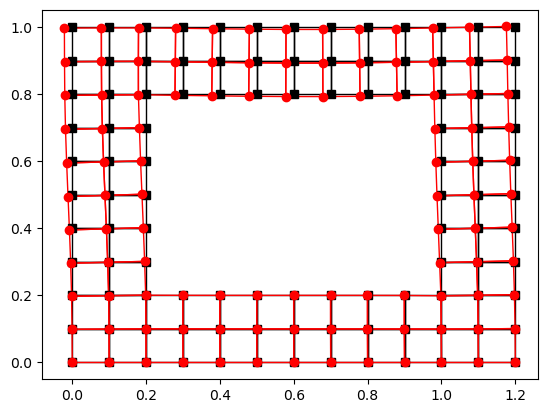

In [21]:
#plt.rc('figure', figsize=(70,50))
sdef=100000000


d_e = np.array(dglobal).astype(np.float64)

plt.plot(XYZ[:, 0],
         XYZ[:, 1], 'sk')
plt.plot(XYZ[:, 0] + sdef*d_e[0:2*len(XYZ)-1:2],
         XYZ[:, 1] + sdef*d_e[1:2*len(XYZ):2], 'or')

for i in CON1:
        plt.fill(XYZ[i, 0],XYZ[i, 1], edgecolor='k', fill=False)
XYZdef =np.zeros((np.shape(XYZ)))
for i in range(len(XYZ)):
        XYZdef[i,0] = XYZ[i,0]+sdef*d_e[2*i]
        XYZdef[i,1] = XYZ[i,1]+sdef*d_e[2*i+1]
for i in CON1:
        plt.fill(XYZdef[i, 0],XYZdef[i, 1], edgecolor='r', fill=False)

plt.show()







### Calculate and plot contours for the Von Mises stress

In [22]:
print(dglobal)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.61464020e-12 -1.26189006e-11
 -2.23170427e-12 -4.04484461e-12 -2.53555177e-12  1.72210260e-12
 -3.54482560e-12  1.65771963e-12 -2.63939969e-12  3.35207595e-13
 -2.04261897e-12  5.44392340e-14 -1.98196810e-12 -3.11037339e-15
 -2.52383876e-12 -6.32220560e-14 -3.82374026e-12 -4.40326396e-13
 -5.81494569e-12 -2.78639115e-12 -4.92445748e-12 -4.66918587e-12
 -3.90000555e-12  6.30270138e-13 -6.14098873e-12  1.05828407e-11
 -1.81094524e-11 -2.65515050e-11 -1.40420253e-11 -8.83398757e-12
 -1.09168794e-11  5.26165059e-12 -5.06356058e-12  1.15769918e-12
 -3.20500715e-12  2.60109

In [23]:
nel= len(CON1)
Von_Mises = np.zeros(nel)
for i in range(nel):
    sigma_mat = np.array([[sigma[0,i],sigma[2,i],0.0],
                          [sigma[2,i],sigma[1,i],0.0],
                          [0.0,0.0,0.0]])
    sigma11 = sigma[0,i]
    sigma22 = sigma[1,i]
    sigma21 = sigma[2,i]
    sigma13 = 0.0
    sigma23 = 0.0
    sigma33 = 0.0
    Von_Mises[i] = np.sqrt((0.5)*(((sigma11-sigma22)**2)+((sigma22-sigma33)**2)+((sigma33-sigma11)**2)+(6*((sigma21**2)+(sigma23**2)+(sigma13**2)))))
               
print(Von_Mises)

[0.13218892 0.02000244 0.0416089  0.04303263 0.02632537 0.02105457
 0.02396282 0.03665467 0.07002931 0.08798647 0.03688918 0.08891041
 0.15228625 0.02319958 0.08795031 0.03119016 0.01274014 0.00698697
 0.01111424 0.02097173 0.04606474 0.14330773 0.06412385 0.1028113
 0.14682835 0.07858282 0.15833188 0.09917978 0.11337567 0.04783093
 0.08651603 0.06945149 0.07938897 0.06144227 0.04540867 0.05057953
 0.05591419 0.08945234 0.01819002 0.05307167 0.05437486 0.12323707
 0.00808726 0.05485268 0.0645132  0.15681588 0.03431858 0.04810939
 0.06838494 0.06313    0.13341204 0.06750242 0.03963112 0.03074583
 0.03271711 0.03301072 0.03051223 0.04300855 0.05196802 0.04072281
 0.04259242 0.06536237 0.07185254 0.06162805 0.05981607 0.0718758
 0.08079863 0.08158624 0.07385196 0.05746324 0.04130601 0.00857007]


In [24]:
nel= CON1[:,0].shape[0]
V_mat = np.zeros(nel)
#print("sigma shape: ", sigma.shape)
for i in range(nel):
    #sigma_mat = sym.Matrix([[sigma[0,i],sigma[2,i]],[sigma[2,i],sigma[1,i]]]) #2x2
    sigma_mat = np.array([[sigma[0,i],sigma[2,i],0.0],
                          [sigma[2,i],sigma[1,i],0.0],
                          [0.0,0.0,0.0]],dtype=float)

    eigval = np.linalg.eigvals(sigma_mat)
    sigma11 = max(eigval)
    sigma33 = min(eigval)
    sigma22 = np.trace(sigma_mat) - (sigma11 + sigma33)
    V_mat[i] = np.sqrt(0.5*((sigma11 - sigma22)**2 + (sigma22-sigma33)**2 + (sigma33 - sigma11)**2))

In [25]:
#print(len(Von_Mises))
#print(len(CON1))
print(max(V_mat))

0.15833188464428824


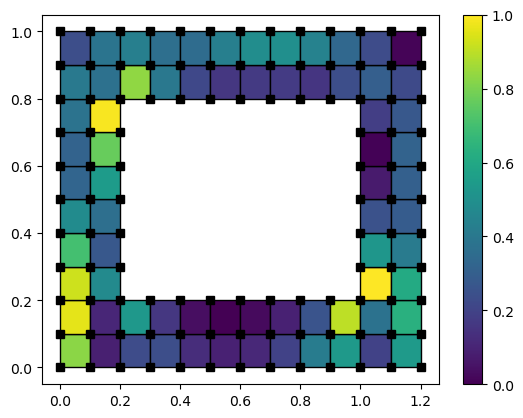

0.04160890144903704
0.008570065647813692
0.1583318846442882


In [26]:
import matplotlib as mpl
#plt.rc('figure', figsize=(70,50))
cmap = mpl.colormaps['viridis']
plt.plot(XYZ[:, 0],
         XYZ[:, 1], 'sk')

norm = plt.Normalize(vmin=np.min(Von_Mises), vmax=np.max(Von_Mises))
rgba = []
for i in range(len(CON1)):
    rgba.append(cmap(norm(Von_Mises[i])))

for j,i in enumerate(CON1):
        plt.fill(XYZ[i, 0],XYZ[i, 1], edgecolor='k', facecolor=rgba[j])

dummy = [plt.scatter([], [], color=rgba[i], label=str(i+1)) for i in range(len(CON1))]

plt.colorbar()

plt.show()
plt.show()
